# Simple Recurrent Neural Networks

This notebook is inspired by the book "Hands-On Machine with Scikit-Learn , Keras & TensorFlow" chapter 15, but here we use PyTorch instead of Keras.

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

In [2]:
# see: https://pythonforfinance.net/2016/11/28/monte-carlo-simulation-in-python/
def random_walk(n_steps, starting_value, mu, sigma):
    daily_returns = np.random.normal(mu/n_steps, sigma/np.sqrt(n_steps), n_steps)+1
    time_series = []
    time_series.append(starting_value)
    
    for daily_return in daily_returns:
        time_series.append(time_series[-1] * daily_return)
    
    return time_series

In [3]:
NUM_SEQUENCES = 10000
N_STEPS = 100
STARTING_VALUE = 100

In [4]:
time_series = []
for sequence in range(NUM_SEQUENCES):
    mu = random.gauss(0, 0.3)
    sigma = abs(random.gauss(0, 0.2))
    
    
    time_series.append(random_walk(N_STEPS, STARTING_VALUE, mu, sigma))

time_series = np.array(time_series)
time_series = time_series[..., np.newaxis]

In [5]:
time_series.shape

(10000, 101, 1)

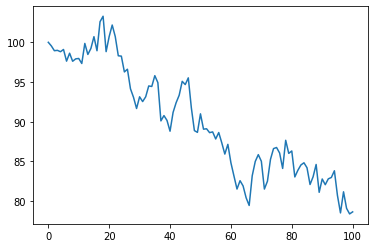

In [6]:
plt.plot(time_series[0])

In [7]:
X_train, y_train = time_series[:7000, :N_STEPS], time_series[:7000, -1]
X_valid, y_valid = time_series[7000:9000, :N_STEPS], time_series[7000:9000, -1]
X_test, y_test = time_series[9000, :N_STEPS], time_series[9000, -1]

In [8]:
X_train.shape

(7000, 100, 1)

## Neural Network paramteters

In [9]:
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.001

## Create Dataset and Dataloader

In [10]:
class TS_Dataset(Dataset):
    def __init__(self, x, y):
        super(TS_Dataset, self).__init__()
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [11]:
train_ds = TS_Dataset(X_train, y_train)
valid_ds = TS_Dataset(X_valid, y_valid)
test_ds = TS_Dataset(X_test, y_test)

In [12]:
train_dataloader = DataLoader(dataset=train_ds, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset=test_ds, shuffle=True, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(dataset=valid_ds, shuffle=True, batch_size=BATCH_SIZE)

## Train and Test functions

In [13]:
#train function
def train(epochs, data_loader, model, optimizer):
    for epoch in tqdm(range(epochs)):
        losses = []
        for x, y in data_loader:
            preds = model(x)

            #mean square root error
            
            loss = (preds - y).pow(2).sqrt().mean()
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            losses.append(loss.detach().item())
            

        print(np.array(losses).mean())


In [14]:
def test(data_loader, model):
    losses = []
    for x, y in data_loader:
        with torch.no_grad():
            preds = model(x)

            #mean square root error
            loss = (preds - y).pow(2).sqrt().mean()
            losses.append(loss.detach().item())

    print(np.array(losses).mean())


## Baseline Metrics

### Naive Forecasting

In [15]:
metric = nn.MSELoss()

In [16]:
y_pred = X_valid[:, -1]

In [17]:
loss = metric(torch.tensor(y_valid), torch.tensor(y_pred))

In [18]:
# naive forecasting
loss.item()

5.584623755953029

### Linear Regression

In [19]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc = nn.Linear(in_features=N_STEPS, out_features=1)
        
    def forward(self, x):
        x = x.view(-1, x.shape[1] * x.shape[2])
        x = self.fc(x)
        return x

In [20]:
fc_model = FC()
fc_optimizer = optim.Adam(fc_model.parameters(), lr=LR)

In [21]:
train(EPOCHS, train_dataloader, fc_model, fc_optimizer)

  0%|          | 0/20 [00:00<?, ?it/s]

8.568820853211564
3.6283807482349273
3.1354273143968627
2.975725065627599
2.8161066345972556
2.7118225549454014
2.6317244583068917
2.5756018472044437
2.5381619086548617
2.505088991770461
2.426044875083993
2.43701924744262
2.5906297420257847
2.296968643523787
2.378154080208034
2.3660253019637714
2.254390325176117
2.328324553629035
2.228806768922501
2.2912163429608627


In [22]:
test(valid_dataloader, fc_model)

1.983227949293833


## Simple RNN

In [23]:
test = nn.RNN(input_size=5, hidden_size=2, num_layers=1, batch_first=True)

In [24]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        #input_size is the dimensionality of the input (1 in the case of our univariate timeseries)
        #hidden_size is the dimensionality of the output of the single cell
        self.rnn = nn.RNN(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc = nn.Linear(5, 1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(1, batch_size, 5)
        
        _, h = self.rnn(x, h0)
        h = h[0]
        return self.fc(h)

In [25]:
rnn_model = RNN()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=LR)

In [26]:
train(EPOCHS, train_dataloader, rnn_model, rnn_optimizer)

  0%|          | 0/20 [00:00<?, ?it/s]

103.96871045953063
102.14590753703357
100.8379280752243
99.50045992359179
98.18504009508106
96.89501113543227
95.57277024499902
94.25735752332156
92.92721665613183
91.62750801539312
90.30601567655938
89.00395704295538
87.67561709608661
86.36526050306347
85.05668988510898
83.72985059485588
82.43832183210817
81.1267639229831
79.8182601928711
78.49162989228827
